In [1]:
import numpy as np
from functools import reduce
import pandas as pd
import xarray as xr
import dask 
import os

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['font.size'] = 18
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["axes.linewidth"] = 2.50

import cartopy.crs as ccrs
import regionmask

## Checking the metrics

### Preliminaries

In [ ]:
###################
# Models
###################
from utils import nex_ssp_dict, cil_ssp_dict, isimip_ssp_dict, gardsv_ssp_dict, gardsv_var_dict, deepsdbc_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if 'pr' in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

In [ ]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=1, memory='15GB', resource_spec='pmem=15GB',
                     worker_extra_args=['#PBS -l feature=rhel7'], 
                     walltime='00:10:00')

cluster.scale(jobs=5)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

client

### Plots

In [3]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/'
path_out = '/storage/home/dcl5300/work/lafferty-sriver_inprep_tbd/figs/supplementary/'

In [4]:
def make_metric_plot(ensemble, model, ssps, path_in, metric, var_id, path_out):
    out_str = path_out + metric + '/' + var_id + '/' + ensemble + '_' + model + '_' + metric + '_' + var_id + '.png'
    if os.path.isfile(out_str):
        return('Already done')
    else:
        # Figure details
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,6),
                               subplot_kw=dict(projection=ccrs.PlateCarree()))
        axs = axs.flatten()

        fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.01)
        
        fig.suptitle(ensemble + '_' + model + '_' + metric + '_' + var_id, fontsize=12, fontweight='bold', y=0.95)

        # Read netcdf or zarr
        if ensemble in ['cil-gdpcir', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + ensemble + '/' + metric + '/' + model, engine='zarr')
        elif ensemble == 'isimip3b':
            ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        else:
            ds = xr.open_dataset(path_in + ensemble + '/' + metric + '/' + model + '.nc')
        
        # Slice
        ds = ds.sel(lat=slice(-60,90))
        
        # Select variable
        if var_id in list(ds.data_vars):
            ds = ds[var_id]
            
        # Plot by ssp
        for idx, ssp in enumerate(ssps):
            # hard-code the one exception
            if (ensemble == 'DeepSD-BC') and (ssp == 'ssp585') and (var_id == 'pr') and (model == 'MRI-ESM2-0'):
                continue
            else:
                try:
                    p = ds.sel(ssp=ssp).isel(time=80).plot(transform=ccrs.PlateCarree(),
                                                                add_colorbar=False,
                                                                ax=axs[idx], levels=11)
                    axs[idx].set_title(ssp)
                    map_exists = True
                except:
                    axs[idx].set_title(ssp + ' ERROR')
                    map_exists = False
        
        # Single colorbar
        if map_exists:
            cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.02])

            cbar = fig.colorbar(p, cax=cbar_ax,
                                orientation='horizontal',
                                label=metric + ' ' + var_id)
        
        plt.savefig(out_str, dpi=300)

In [9]:
%%time
################
# avg, max
###############
delayed_res = []
for metric in ['avg', 'max']:
    for var_id in ['tas', 'tasmin', 'tasmax', 'pr']:
        # NEX
        for model in nex_models:
            delayed_res.append(dask.delayed(make_metric_plot)('nex-gddp', model, nex_ssp_dict[model], path_in, metric, var_id, path_out))
            
        # CIL
        for model in cil_models:
            delayed_res.append(dask.delayed(make_metric_plot)('cil-gdpcir', model, cil_ssp_dict[model], path_in, metric, var_id, path_out))

        # ISIMIP
        for model in isi_models:
            delayed_res.append(dask.delayed(make_metric_plot)('isimip3b', model, isimip_ssp_dict[model], path_in + 'isimip3b/regridded/conservative/', metric, var_id, path_out))
            
        # GARD-SV
        if var_id == 'pr':
            model_list = cbp_gard_precip_models
        else: 
            model_list = cbp_gard_models
        for model in model_list:
            delayed_res.append(dask.delayed(make_metric_plot)('GARD-SV', model, gardsv_ssp_dict[model], path_in + 'carbonplan/regridded/conservative/', metric, var_id, path_out))
        
        # DeepSD-BC
        for model in cbp_deep_models:
            delayed_res.append(dask.delayed(make_metric_plot)('DeepSD-BC', model, deepsdbc_dict[model].keys(), path_in + 'carbonplan/native_grid/', metric, var_id, path_out))
            
################
# max5d
#################
metric = 'max5d'
var_id = 'RX5day'

# NEX
for model in nex_models:
    delayed_res.append(dask.delayed(make_metric_plot)('nex-gddp', model, nex_ssp_dict[model], path_in, metric, var_id, path_out))
    
# CIL
for model in cil_models:
    delayed_res.append(dask.delayed(make_metric_plot)('cil-gdpcir', model, cil_ssp_dict[model], path_in, metric, var_id, path_out))

# ISIMIP
for model in isi_models:
    delayed_res.append(dask.delayed(make_metric_plot)('isimip3b', model, isimip_ssp_dict[model], path_in + 'isimip3b/regridded/conservative/', metric, var_id, path_out))
    
# GARD-SV
for model in cbp_gard_precip_models:
    delayed_res.append(dask.delayed(make_metric_plot)('GARD-SV', model, gardsv_ssp_dict[model], path_in + 'carbonplan/regridded/conservative/', metric, var_id, path_out))

# DeepSD-BC
for model in cbp_deep_models:
    delayed_res.append(dask.delayed(make_metric_plot)('DeepSD-BC', model, deepsdbc_dict[model].keys(), path_in + 'carbonplan/native_grid/', metric, var_id, path_out))

#############
# dry
#############
metric = 'dry'

for var_id in ['count_eq_0', 'count_lt_1', 'streak_eq_0', 'streak_lt_1']:
    # NEX
    for model in nex_models:
        delayed_res.append(dask.delayed(make_metric_plot)('nex-gddp', model, nex_ssp_dict[model], path_in, metric, var_id, path_out))
        
    # CIL
    for model in cil_models:
        delayed_res.append(dask.delayed(make_metric_plot)('cil-gdpcir', model, cil_ssp_dict[model], path_in, metric, var_id, path_out))

    # ISIMIP
    for model in isi_models:
        delayed_res.append(dask.delayed(make_metric_plot)('isimip3b', model, isimip_ssp_dict[model], path_in + 'isimip3b/regridded/conservative/', metric, var_id, path_out))
        
    # GARD-SV
    for model in cbp_gard_precip_models:
        delayed_res.append(dask.delayed(make_metric_plot)('GARD-SV', model, gardsv_ssp_dict[model], path_in + 'carbonplan/regridded/conservative/', metric, var_id, path_out))
    
    # DeepSD-BC
    for model in cbp_deep_models:
        delayed_res.append(dask.delayed(make_metric_plot)('DeepSD-BC', model, deepsdbc_dict[model].keys(), path_in + 'carbonplan/native_grid/', metric, var_id, path_out))
            
            
# Compute
print(len(delayed_res))
res = dask.compute(*delayed_res)

701
CPU times: user 1.73 s, sys: 123 ms, total: 1.85 s
Wall time: 8.49 s


## Historical quantile comparison

In [2]:
# Read all
era5_temp = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/quantiles/era5_temperature_quantiles_gardsv/', engine='zarr')
era5_prcp = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/quantiles/era5_precip_quantiles_gardsv/', engine='zarr')

gmfd_temp = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/quantiles/gmfd_temperature_quantiles_gardsv.nc')
gmfd_prcp = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/quantiles/gmfd_precip_quantiles_gardsv.nc')

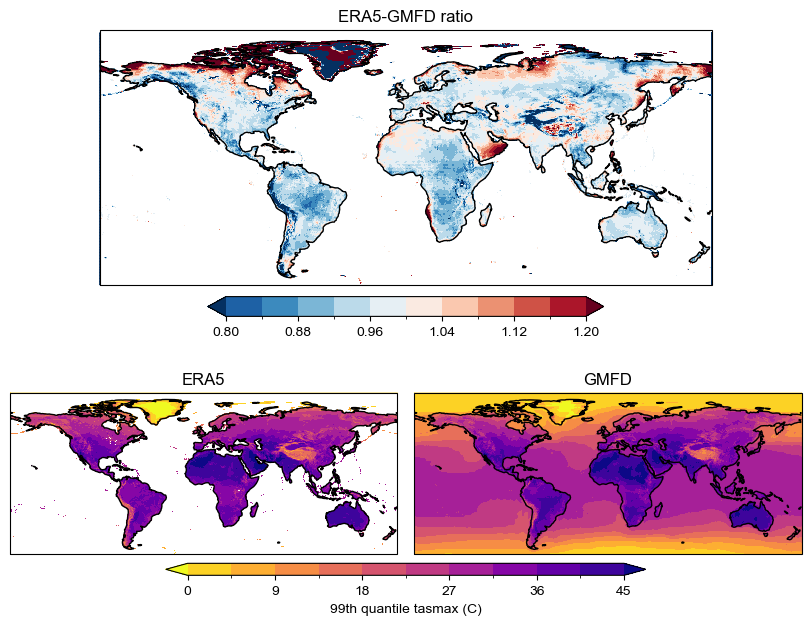

In [11]:
# 99th tasmax temperature quantiles
fig = plt.figure(figsize=(8, 6), layout='constrained')

spec = fig.add_gridspec(2, 2,
                        bottom=0.3, top=0.9, left=0.1, right=0.9,
                        wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_temp.tasmax_q99 / gmfd_temp.tasmax_q99).sel(lat=slice(-60,90))
ratio.plot(ax=ax0,
           transform=ccrs.PlateCarree(),
           vmin=0.8, vmax=1.2, cmap='RdBu_r', levels=11,
           cbar_kwargs={'orientation':'horizontal',
                        'label':None,
                        'shrink':0.5, 'pad':0.04})
ax0.coastlines()
ax0.set_title('ERA5-GMFD ratio')

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_temp.tasmax_q99.sel(lat=slice(-60,90)).plot(ax=ax10,
                                                 transform=ccrs.PlateCarree(),
                                                 levels=11,
                                                 add_colorbar=False,
                                                 vmin=0, vmax=45, cmap='plasma_r')
ax10.set_title('ERA5')
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_temp.tasmax_q99.sel(lat=slice(-60,90)).plot(ax=ax11,
                                                     transform=ccrs.PlateCarree(),
                                                     levels=11,
                                                     add_colorbar=False,
                                                     vmin=0, vmax=45, cmap='plasma_r')

ax11.set_title('GMFD')
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

cbar = fig.colorbar(p, cax=cbar_ax,
                    orientation='horizontal',
                    label = '99th quantile tasmax (C)')

plt.show()

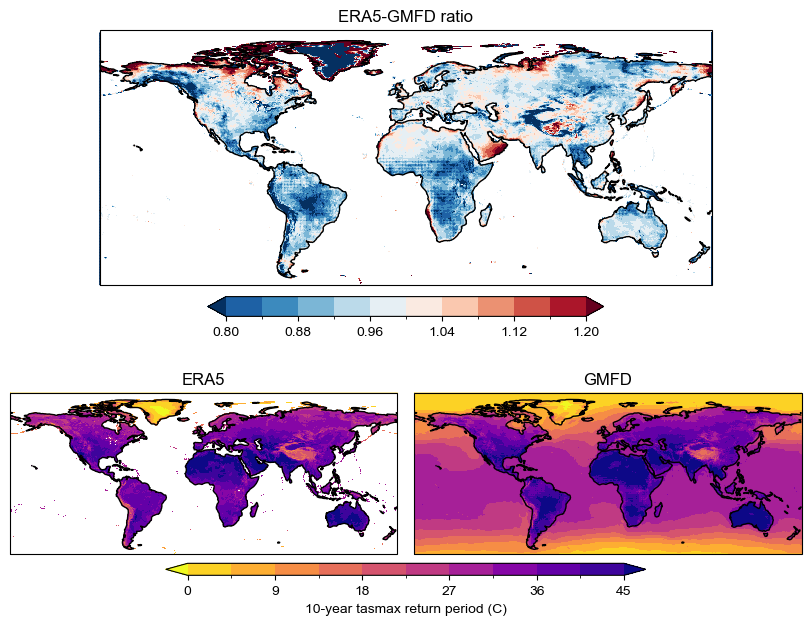

In [9]:
# 10-year tasmax return period
fig = plt.figure(figsize=(8, 6), layout='constrained')

spec = fig.add_gridspec(2, 2,
                        bottom=0.3, top=0.9, left=0.1, right=0.9,
                        wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_temp.tasmax_rp10 / gmfd_temp.tasmax_rp10).sel(lat=slice(-60,90))
ratio.plot(ax=ax0,
           transform=ccrs.PlateCarree(),
           vmin=0.8, vmax=1.2, cmap='RdBu_r', levels=11,
           cbar_kwargs={'orientation':'horizontal',
                        'label':None,
                        'shrink':0.5, 'pad':0.04})
ax0.coastlines()
ax0.set_title('ERA5-GMFD ratio')

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_temp.tasmax_rp10.sel(lat=slice(-60,90)).plot(ax=ax10,
                                                 transform=ccrs.PlateCarree(),
                                                 levels=11,
                                                 add_colorbar=False,
                                                 vmin=0, vmax=45, cmap='plasma_r')
ax10.set_title('ERA5')
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_temp.tasmax_rp10.sel(lat=slice(-60,90)).plot(ax=ax11,
                                                     transform=ccrs.PlateCarree(),
                                                     levels=11,
                                                     add_colorbar=False,
                                                     vmin=0, vmax=45, cmap='plasma_r')

ax11.set_title('GMFD')
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

cbar = fig.colorbar(p, cax=cbar_ax,
                    orientation='horizontal',
                    label = '10-year tasmax return period (C)')

plt.show()

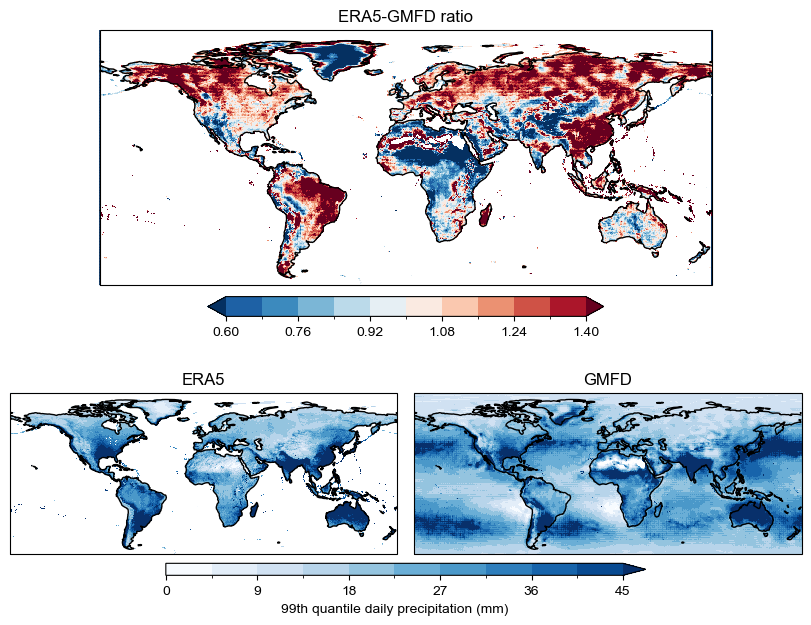

In [3]:
# 99th precip quantiles
fig = plt.figure(figsize=(8, 6), layout='constrained')

spec = fig.add_gridspec(2, 2,
                        bottom=0.3, top=0.9, left=0.1, right=0.9,
                        wspace=0.00, hspace=0.01)

# Ratio
ax0 = fig.add_subplot(spec[0, :], projection=ccrs.PlateCarree())
ratio = (era5_prcp.pr_q99 / gmfd_prcp.pr_q99).sel(lat=slice(-60,90))
ratio.plot(ax=ax0,
           transform=ccrs.PlateCarree(),
           vmin=0.6, vmax=1.4, cmap='RdBu_r', levels=11,
           cbar_kwargs={'orientation':'horizontal',
                        'label':None,
                        'shrink':0.5, 'pad':0.04})
ax0.coastlines()
ax0.set_title('ERA5-GMFD ratio')

# ERA5
ax10 = fig.add_subplot(spec[1, 0], projection=ccrs.PlateCarree())
era5_prcp.pr_q99.sel(lat=slice(-60,90)).plot(ax=ax10,
                                                 transform=ccrs.PlateCarree(),
                                                 levels=11,
                                                 add_colorbar=False,
                                                 vmin=0, vmax=45, cmap='Blues')
ax10.set_title('ERA5')
ax10.coastlines()

# GMFD
ax11 = fig.add_subplot(spec[1, 1], projection=ccrs.PlateCarree())
p = gmfd_prcp.pr_q99.sel(lat=slice(-60,90)).plot(ax=ax11,
                                                     transform=ccrs.PlateCarree(),
                                                     levels=11,
                                                     add_colorbar=False,
                                                     vmin=0, vmax=45, cmap='Blues')

ax11.set_title('GMFD')
ax11.coastlines()

# Add colorbar
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

cbar = fig.colorbar(p, cax=cbar_ax,
                    orientation='horizontal',
                    label = '99th quantile daily precipitation (mm)')

plt.show()

## Example plots

In [2]:
###################
# Models
###################
from utils import nex_ssp_dict, cil_ssp_dict, isimip_ssp_dict, gardsv_ssp_dict, gardsv_var_dict, deepsdbc_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if 'pr' in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

In [3]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
nex_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/'
cil_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/'
isi_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/'
cbp_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/carbonplan/'

out_path = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/'
poly_path = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/forced_response_polynomial/'

In [4]:
def read_and_process(ensemble, path_in, model, metric, submetric, submetric_var, lat, lon):
    # Read netcdf or zarr
    if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
        ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
    elif ensemble in ['CIL', 'DeepSD-BC']:
        ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
        
    # Select submetric if chosen
    if submetric:
        ds = ds[submetric]
    
    # Common preprocessing
    ds['time'] = ds.indexes['time'].year
    if ds.lon.max() > 180:
        ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
        ds = ds.sortby('lon')
        
    # DeepSD-BC still has member_id
    if ensemble == 'DeepSD-BC':
        ds = ds.isel(member_id=0)
        
    # Select lat, lon
    ds = ds.sel(lat=lat, lon=lon, method='nearest')
    
    # Construct dataframe
    df_tmp = ds.to_dataframe().drop(columns=['lat', 'lon']).reset_index()
    df_tmp['ensemble'] = ensemble
    df_tmp['model'] = model
    
    return df_tmp

In [5]:
def read_and_process_forced(ensemble, path_in, model, metric, submetric, submetric_var, lat, lon):
    poly_str = path_in + metric + '/'
    ds = xr.open_dataset(poly_str + ensemble + '_' + model + '.nc')
    ds['time'] = ds.indexes['time'].year
    
    # Select submetric if chosen
    if submetric:
        ds = ds[submetric]
        
        
    # DeepSD-BC still has member_id
    if ensemble == 'DeepSD-BC':
        ds = ds.isel(member_id=0)
        
    # Select lat, lon
    ds = ds.sel(lat=lat, lon=lon, method='nearest')
    
    # Construct dataframe
    df_tmp = ds.to_dataframe().drop(columns=['lat', 'lon']).reset_index()
    df_tmp['ensemble'] = ensemble
    df_tmp['model'] = model
    
    return df_tmp

### Probability distributions

In [14]:
# Chicago, IL
lat, lon = 41.882, -87.628

# Common models
models = ['CanESM5', 'EC-Earth3', 'GFDL-ESM4', 'MIROC6', 'UKESM1-0-LL']

var_id = 'tasmax'

In [16]:
# Read all combinations
df = pd.DataFrame(columns = ['time', 'model', 'ensemble', 'ssp', var_id])

# NEX
for model in models:
    df_tmp = read_and_process('NEX', nex_in, model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])
        
# CIL
for model in models:
    df_tmp = read_and_process('CIL', cil_in, model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])
        
# ISIMIP
for model in models:
    df_tmp = read_and_process('ISIMIP', isi_in, model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])
        
# GARD-SV
for model in models:
    if model in cbp_gard_models:
        df_tmp = read_and_process('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, 'max', var_id, False, lat, lon)
        df = pd.concat([df, df_tmp])
        
# DeepSD-BC
for model in models:
    if model in cbp_deep_models:
        df_tmp = read_and_process('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, 'max', var_id, False, lat, lon)
        df = pd.concat([df, df_tmp])

In [17]:
# Select mid-century
df_mid = df.query('time >= 2045 and time <= 2055')

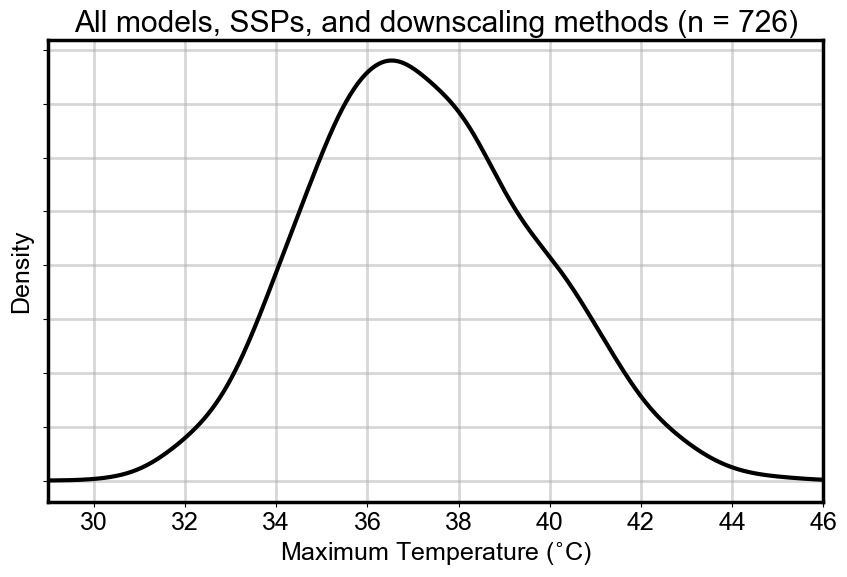

In [32]:
# Raw plot 
fig, ax = plt.subplots(figsize=(10,6))

df_mid[var_id].plot.kde(ax=ax, color='black', lw=3)

ax.set_title('All models, SSPs, and downscaling methods (n = ' + str(len(df_mid)) + ')')
ax.set_xlabel('Maximum Temperature ($\!^\circ\!$C)')
ax.set_xlim([29,46])
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.savefig('../figs/supplementary/timeseries/Chicago_max_' + var_id + '_raw.png', dpi=600)

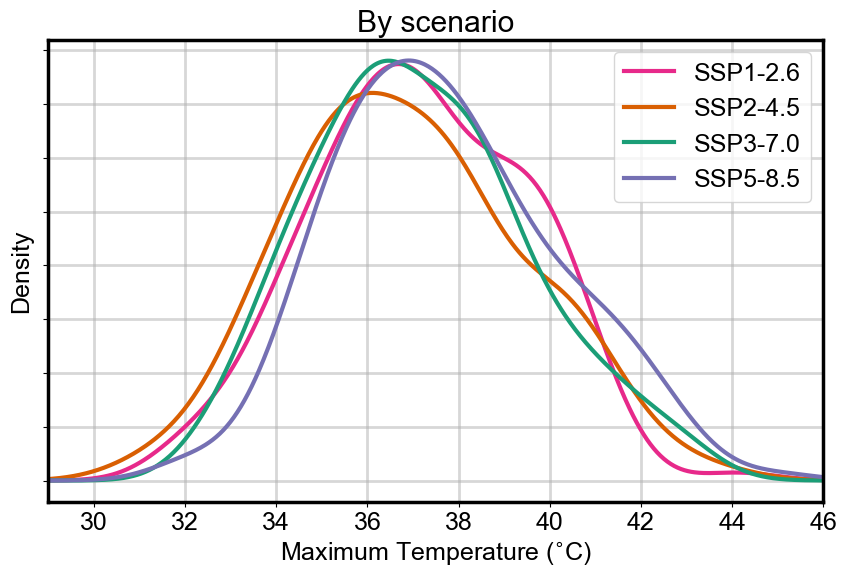

In [29]:
# SSP plot 
ssp_color_dict = {'ssp126':'#e7298a', 'ssp245':'#d95f02', 'ssp370':'#1b9e77', 'ssp585':'#7570b3'}

fig, ax = plt.subplots(figsize=(10,6))

df_mid.query('ssp == "ssp126"')[var_id].plot.kde(ax=ax, color=ssp_color_dict['ssp126'], 
                                                   label='SSP1-2.6',
                                                   lw=3)
df_mid.query('ssp == "ssp245"')[var_id].plot.kde(ax=ax, color=ssp_color_dict['ssp245'],
                                                   label='SSP2-4.5',
                                                   lw=3)
df_mid.query('ssp == "ssp370"')[var_id].plot.kde(ax=ax, color=ssp_color_dict['ssp370'],
                                                   label='SSP3-7.0',
                                                   lw=3)
df_mid.query('ssp == "ssp585"')[var_id].plot.kde(ax=ax, color=ssp_color_dict['ssp585'],
                                                   label='SSP5-8.5',
                                                   lw=3)

ax.set_title('By scenario')
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel('Maximum Temperature ($\!^\circ\!$C)')
ax.set_xlim([29,46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig('../figs/supplementary/timeseries/Chicago_max_' + var_id + '_ssp.png', dpi=600)

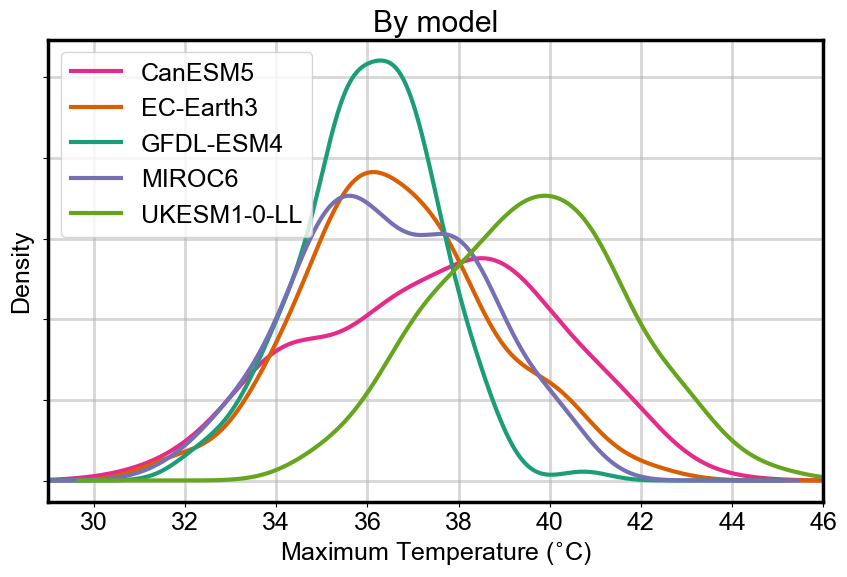

In [33]:
# Model plot 
# models = reduce(lambda a, b: np.unique(np.append(a,b)), [nex_models, cil_models, isi_models])
model_color_dict = {models[0]:'#e7298a', models[1]:'#d95f02', models[2]:'#1b9e77', models[3]:'#7570b3', models[4]:'#66a61e'}

fig, ax = plt.subplots(figsize=(10,6))

for model in models:
    df_mid[df_mid.model == model][var_id].plot.kde(ax=ax, color=model_color_dict[model], lw=3,
                                                    label = model)

ax.set_title('By model')
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel('Maximum Temperature ($\!^\circ\!$C)')
ax.set_xlim([29,46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig('../figs/supplementary/timeseries/Chicago_max_' + var_id + '_models.png', dpi=600)

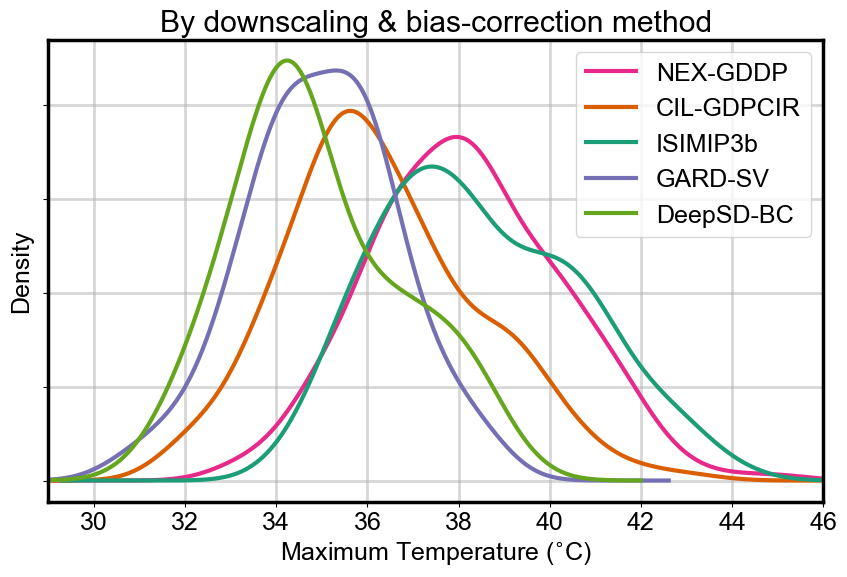

In [31]:
# Ensemble plot
ens_color_dict = {'NEX':'#e7298a', 'CIL':'#d95f02', 'ISIMIP':'#1b9e77', 'GARD-SV':'#7570b3', 'DeepSD-BC':'#66a61e'}

fig, ax = plt.subplots(figsize=(10,6))

df_mid.query('ensemble == "NEX"')[var_id].plot.kde(ax=ax, color=ens_color_dict['NEX'], label='NEX-GDDP', lw=3)
df_mid.query('ensemble == "CIL"')[var_id].plot.kde(ax=ax, color=ens_color_dict['CIL'], label='CIL-GDPCIR', lw=3)
df_mid.query('ensemble == "ISIMIP"')[var_id].plot.kde(ax=ax, color=ens_color_dict['ISIMIP'], label='ISIMIP3b', lw=3)
df_mid.query('ensemble == "GARD-SV"')[var_id].plot.kde(ax=ax, color=ens_color_dict['GARD-SV'], label='GARD-SV', lw=3)
df_mid.query('ensemble == "DeepSD-BC"')[var_id].plot.kde(ax=ax, color=ens_color_dict['DeepSD-BC'], label='DeepSD-BC', lw=3)

ax.set_title('By downscaling & bias-correction method')
# ax.set_xlabel('Precipitation (mm)')
# ax.set_xlim([0,150])
ax.set_xlabel('Maximum Temperature ($\!^\circ\!$C)')
ax.set_xlim([29,46])
ax.set_yticklabels([])
ax.grid(alpha=0.5, lw=2)
plt.legend()
plt.savefig('../figs/supplementary/timeseries/Chicago_max_' + var_id + '_ens.png', dpi=600)

### Timeseries

In [6]:
# Chicago, IL
lat, lon = 41.882, -87.628

# Metric
var_id = 'tasmax'

In [2]:
df

NameError: name 'df' is not defined

In [ ]:
# Read all combinations
df = pd.DataFrame(columns = ['time', 'model', 'ensemble', 'ssp', var_id])

# NEX
for model in nex_models:
    df_tmp = read_and_process('NEX', nex_in, model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])
        
# CIL
for model in cil_models:
    df_tmp = read_and_process('CIL', cil_in, model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])
        
# ISIMIP
for model in isi_models:
    df_tmp = read_and_process('ISIMIP', isi_in, model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])
        
# GARD-SV
for model in cbp_gard_models:
    df_tmp = read_and_process('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])
        
# DeepSD-BC
for model in cbp_deep_models:
    df_tmp = read_and_process('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, 'max', var_id, False, lat, lon)
    df = pd.concat([df, df_tmp])

In [ ]:
df[df.time == 2050].var()

In [67]:
# Read all combinations
df_forced = pd.DataFrame(columns = ['time', 'model', 'ensemble', 'ssp', var_id])

# NEX
for model in nex_models:
    df_tmp = read_and_process_forced('NEX', poly_path, model, 'max', var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])
        
# CIL
for model in cil_models:
    df_tmp = read_and_process_forced('CIL', poly_path, model, 'max', var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])
        
# ISIMIP
for model in isi_models:
    df_tmp = read_and_process_forced('ISIMIP', poly_path, model, 'max', var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])
        
# GARD-SV
for model in cbp_gard_models:
    df_tmp = read_and_process_forced('GARD-SV', poly_path, model, 'max', var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])
        
# DeepSD-BC
for model in cbp_deep_models:
    df_tmp = read_and_process_forced('DeepSD-BC', poly_path, model, 'max', var_id, False, lat, lon)
    df_forced = pd.concat([df_forced, df_tmp])

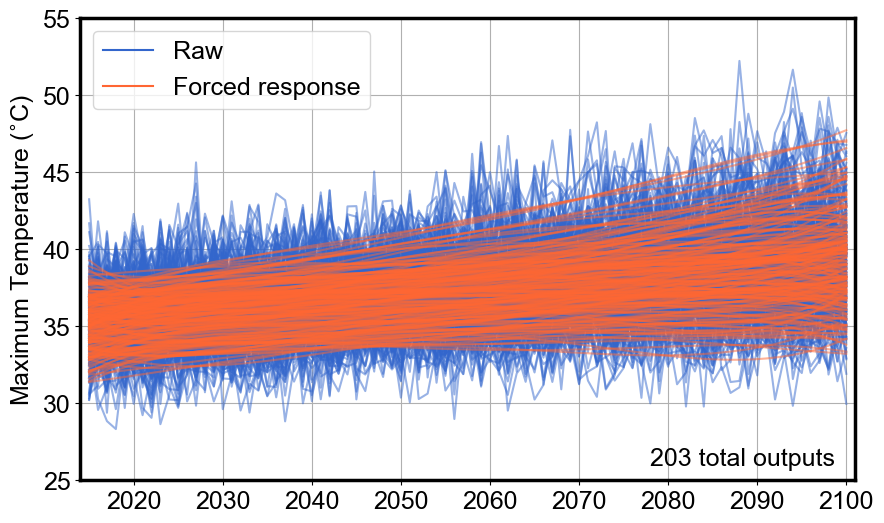

In [89]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot([1,2], [3,4], color='#3366CC', label='Raw')
ax.plot([1,2], [3,4], color='#FF6633', label='Forced response')
ax.legend()

df.groupby(['ensemble', 'model', 'ssp']).plot(x='time', y=var_id, alpha=0.5, color='#3366CC', ax=ax, legend=None)
df_forced.groupby(['ensemble', 'model', 'ssp']).plot(x='time', y=var_id, alpha=0.5, color='#FF6633', ax=ax, legend=None)

ax.set_ylabel('Maximum Temperature ($\!^\circ\!$C)')
ax.set_xlabel('')
ax.text(2078, 26, str(len(df[df.time == 2050])) + ' total outputs')
ax.grid()
ax.set_xlim([2014, 2101])
ax.set_ylim([25, 55])
plt.savefig('../figs/supplementary/timeseries/Chicago_max_tasmax.png', dpi=800)